In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import random
import sys
from IPython.display import clear_output

In [2]:
ratings = pd.read_csv("dataset/MovieLens100K",sep=" ",names=["user_id","item_id","rating","timestamp"])

In [3]:
USERS,ITEMS = ratings.nunique()[:2]
RATINGS = ratings.shape[0]
profiles = [ [] for i in range(USERS) ]
profiles_train = [ [] for i in range(USERS) ]
profiles_test = [ {} for i in range(USERS) ]
V = [ {} for i in range(USERS) ]

support = [0]*ITEMS
for index,row in ratings.iterrows():
  profiles[row['user_id']-1].append(row['item_id']-1)
  
for profile in profiles:
  for item in profile:
    support[item] += 1

In [4]:
precedenceCount = [ [0]*ITEMS for i in range(ITEMS) ]
for profile in profiles:
  for i in range(len(profile)):
    for j in range(i+1,len(profile)):
      precedenceCount[profile[i]][profile[j]] += 1

In [5]:
def scoreP(profile,item):
  pp = []
  top_l = 2
  for l in profile:
    pp.append(precedenceCount[l][item]/support[l])
  pp.sort(reverse=True)
  sc = support[item]/USERS
  for p in pp[:top_l]:
    sc *= p
  return sc

def scoreR(profile,item):
  pp = []
  top_l = 2
  for l in profile:
    pp.append(profile[l]*precedenceCount[l][item]/support[l])
  pp.sort(reverse=True)
  sc = support[item]/USERS
  for p in pp[:top_l]:
    sc *= p
  return sc

In [6]:
def conformal( profile_wt , profile ,precedenceCount , rec_candidates , Epsilon , top_K ,group , G):
  n = len(profile)
  recommendations = {}
  
  Vg = set()
  for user in group:
    for v in V[user]:
      Vg.add(v)
  
  avg_r = sum(rec_candidates.values())/len(rec_candidates)
  avg_p = sum(profile_wt.values())/n
  scale = avg_p/avg_r
  
  for r in rec_candidates:
    avg_p = 0
    p_vec = []
    for v in Vg:
      p = 0
      pp_nv =  rec_candidates[r]* scale * precedenceCount[r][v]/support[r]
      for item in profile:
        if profile_wt[item]*precedenceCount[item][v]/support[item] <= pp_nv:
          p += 1
      p /= max(1,len(profile) )
      avg_p += p
    recommendations[r] = avg_p/len(Vg)

  return recommendations

In [7]:
def main( G,top_K,Rounds ):  
  epsilon = [.05*i for i in range(21)]
  validity = {ep:0  for ep in epsilon }
  efficiency = {ep:0  for ep in epsilon }
  
  for run in range(Rounds):
    
    for user in range(USERS):
      n = len(profiles[user])
      profiles_train[user] = profiles[user][:n*45//100]
      temp = profiles[user][n*45//100:]
      random.shuffle(temp)
      V[user] = temp[:n*15//100]
      profiles_test[user] = set(temp[n*15//100:])
    
    r = [ i for i in range(USERS) ]
    random.shuffle(r)
    groups = [ [ r[G*i+j] for j in range(G) ] for i in range(USERS//G) ] 
    ins =0 
    
    for group in groups:
      
      for user in group:
        for item1 in profiles_test[user]:
          support[item1] -= 1
          for item2 in profiles_train[user]:
            precedenceCount[item2][item1] -= 1  
      
      group_items = set({})
      for user in group:
        for item in profiles_train[user]:
          group_items.add(item)
      
      Vg = {} #virtual profile
      Vl = []
      for item in group_items:
        item_score = 0
        for user in group:
          if item in profiles_train[user]:
            item_score += 1
          else:
            item_score += scoreP(profiles_train[user],item)
        Vg[item] = item_score/G
        Vl.append(item)
      # Virtual Profile Created
      
      rec_candidates = {}
      for item in range(ITEMS):
        if item not in group_items and support[item] > 0:
          rec_candidates[item] = scoreR(Vg,item)      
      
      rec_candidates = dict(sorted(rec_candidates.items(),key=itemgetter(1),reverse=True))
      p_val = conformal( Vg , Vl ,precedenceCount , rec_candidates , None , top_K , group , G ) 
#       print(p_val)
      
      for user in group:
        for item1 in profiles_test[user]:
          support[item1] += 1
          for item2 in profiles_train[user]:
            precedenceCount[item2][item1] += 1  
            
      for user in group:
        for ep in epsilon:
          for item in p_val:
            if p_val[item] <= ep and item in profiles_test[user]:
              validity[ep] += 1/len(profiles_test[user])
            if p_val[item] > ep and item not in profiles_test[user]: 
              efficiency[ep] += 1/len(rec_candidates)
              
      ins += G
      clear_output()
      print("Instance :",ins)
      print("Run :",run+1)
      
  for ep in epsilon:
    validity[ep] /= (USERS * Rounds)
    efficiency[ep] /= (USERS * Rounds) 
      
  return epsilon,validity,efficiency

# Validity and Efficiency for group sizes 1-5

In [8]:
b = main(2,10,5)

Instance : 942
Run : 5


In [23]:
def plot(x,y,l):
  plt.plot(x,y.values(),label="Group size:"+str(l))
  plt.legend()
  plt.xlabel("ε")
  plt.ylabel("Error1")
  plt.show()

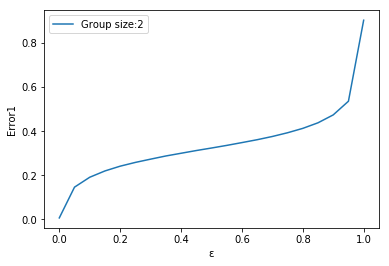

In [24]:
plot(b[0],b[1],2)

In [25]:
def plot(x,y,l):
  plt.plot(x,y.values(),label="Group size:"+str(l))
  plt.legend()
  plt.xlabel("ε")
  plt.ylabel("Error2")
  plt.show()

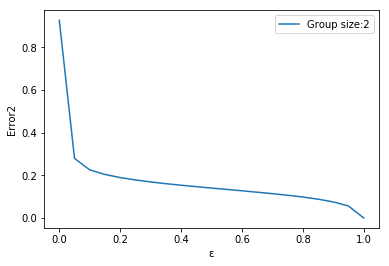

In [4]:
plot(b[0],b[2],2)

In [3]:
# import dill
# dill.load_session('val_eff2.db')

In [27]:
import dill
dill.dump_session('val_eff2.db')